# Analysis of A/B test results for e-commerce website

## Objective

This work is an analysis of A/B test results provided provided from an e-commerce website to test the user response to a new webpage design.

The analysis aims to provide insights that help the decision makers in deciding whether to:
- Implement the new webpage,
- Keep the old webpage, or
- Expand the scope of the A/B testing

## The A/B Test Dataset

Below is a description of each column in the dataset

<center>

|Columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The control group users are expected to be served with old_page; <br>Treatment group users are matched with the new_page. <br>However, **some inaccurate rows** are present in the initial data, such as a control group user is matched with a new_page. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, 1 means yes, the user bought the product.|`[0, 1]`|
</center>

## Part I - EDA and Data Cleaning

In [1]:
#imports

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/home/moelinux/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv('AB-testing-dataset/ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


**Number of unique users:**

In [5]:
df['user_id'].nunique()

290584

**Missing values**

In [6]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

**Bad Data:**
- Number of times when the group is treatment but landing_page is not the new_page
- Number of times when the group is control but landing_page is the new_page

In [7]:
false1= df.query("group=='treatment' and landing_page !='new_page'")
len(false1)

1965

In [8]:
false2= df.query("group=='control' and landing_page !='old_page'")
len(false2)

1928

In [9]:
len(false1) + len(false2)

3893

**Removing bad data**

In [10]:
total_index=false1.index.union(false2.index)
total_index

Int64Index([    22,    240,    308,    327,    357,    490,    685,    713,
               776,    846,
            ...
            293817, 293888, 293894, 293917, 293996, 294014, 294200, 294252,
            294253, 294331],
           dtype='int64', length=3893)

In [11]:
df2= df.drop(total_index)

**Sanity check on bad data removal**

In [12]:
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [13]:
len(df2)

290585

**Removing duplicates**

In [14]:
df2['user_id'].nunique()

290584

In [15]:
df2['user_id'].duplicated().sum()

1

In [16]:
df2[df2['user_id'].duplicated()].user_id

2893    773192
Name: user_id, dtype: int64

In [17]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [18]:
df2= df2.drop_duplicates(subset="user_id")

In [19]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted


**Resetting the data frame index**

In [20]:
df2= df2.reset_index(drop= True)

In [21]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


---

## Part II - Probability Analysis

**Probability of an individual converting regardless of the page they receive**

In [22]:
p_converted = df2['converted'].mean()
p_converted

0.11959708724499628

**Convertion probability | Given that an individual was in the control group**

In [23]:
control_P_population = df2.query("group == 'control'")['converted'].mean()
control_P_population

0.1203863045004612

**Convertion probability | Given that an individual was in the treatment group**

In [24]:
treatment_P_population = df2.query("group == 'treatment'")['converted'].mean()
treatment_P_population

0.11880806551510564

**Observed difference between the conversion rates for the two groups**

In [25]:
observed_diff= treatment_P_population - control_P_population
observed_diff

-0.0015782389853555567

**Visualizing conversion rate probability**

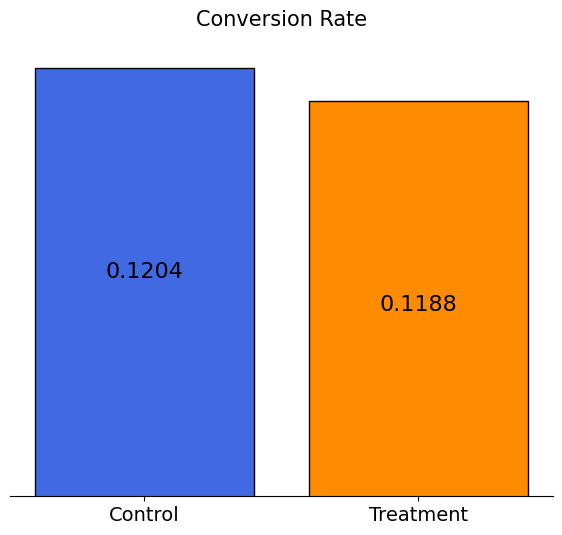

In [26]:
X = ['Control', 'Treatment']
Y = [control_P_population, treatment_P_population]
plt.figure(figsize=(7,6))
plt.bar(X, Y, edgecolor=["black", "black"] , color=['royalblue', 'darkorange'])
for i, g in enumerate(Y):
    plt.text(i, g - 0.01, "{0:.{digits}f}".format(g, digits=4), fontsize=16, fontweight="light", ha="center")

plt.title("Conversion Rate", fontsize=15, fontweight="light" )
plt.ylim(0.10,0.122)
plt.xticks(fontsize=14, fontweight="light")
plt.yticks([])
sns.despine(left=True);

**Probability of an individual receiving the new page**

In [27]:
p_new_page= len(df2.query("landing_page == 'new_page'"))/len(df2)
p_new_page

0.5000619442226688

**Probability of an individual receiving the old page**

In [28]:
p_old_page = 1- p_new_page
p_old_page

0.4999380557773312

**Observations**

- Based on the initial probability analysis, there is no statistically significant evidence that the new page leads to an increase in the conversion rate

- There is no bias landing webpage probability, since each user has 50% probability of receiving either webpage


---

## Part III: A/B Testing (Hypothesis Testing)

**Defining null and alternative hypotheses**

**Hypothesis assumption:** Assuming that the old webpage is better unless the new webpage proves to be better with a significance level α (acceptable Type I error) of 5%

>**$H_0$  Null: $P_{old}$ >= $P_{new}$** 

>**$H_1$  Alternative : $P_{new}$ > $P_{old}$**

while **$p_{old}$** and **$p_{new}$** are the conversion probability (or rate) for the old and new pages respectively

#### Under the null hypothesis $H_0$, we assume that $p_{new}$ and $p_{old}$ are both equal to the converted success rate in the `df2` data regardless of the webpage:

>$P_{new} = P_{old} = P_{population}$

**Approach for Null Hypothesis  $H_0$ testing:**

- Simulating (bootstrapping) sample data set for both groups, and compute the conversion probability $p$ for those samples 
- Using a sample size for each group equal to the ones in the DataFrame "df2" data
- Computing the difference in the conversion probability for the two samples above
- Performing the sampling distribution for the "difference in the convesrion probability" between the two simulated-samples over 10,000 iterations; and calculating an estimate of the difference

**The conversion rate for $p_{new}$ under the null hypothesis**

In [29]:
p_new = p_converted
p_new

0.11959708724499628

**Conversion rate for $p_{old}$ under the null hypothesis**

In [30]:
p_old = p_converted
p_old

0.11959708724499628

**Number of individuals in the treatment group $n_{new}$**

In [31]:
n_new= len(df2.query("landing_page == 'new_page'"))
n_new

145310

**Number of individuals in the control group $n_{old}$**

In [32]:
n_old= len(df2.query("landing_page == 'old_page'"))
n_old

145274

**Simulating (Bootstrapping) Sample for the treatment Group** 
- Creating a NumPy array of 1's and 0's represnting "new_page_converted" or "old_page_converted" with ratios of $n_{new}$ and $n_{old}$ and calculating the conversion difference
- Repeating the same process for 10,000 iterations
- Storing all conversion difference values in a NumPy array "p_diffs"

In [33]:
# Sampling distribution 
p_diffs = []

for i in range(10000):
    sample_new_page = np.random.choice([1, 0], size=n_new, p=[p_new, 1-p_new], replace= True)
    sample_old_page = np.random.choice([1, 0], size=n_old, p=[p_old, 1-p_old], replace= True)
    p_diffs.append(sample_new_page.mean() - sample_old_page.mean())
    
p_diffs = np.array(p_diffs)

**Matching the differences *p_diffs* to the sampling distribution using the 95% confidence interval by displaying them in the histogram**

In [34]:
low, high = np.percentile(p_diffs, 2.5), np.percentile(p_diffs, 97.5)

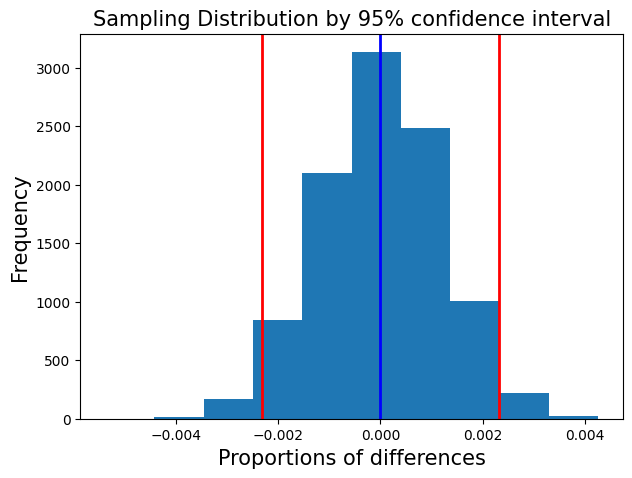

In [47]:
plt.figure(figsize=(7,5))
plt.hist(p_diffs)
plt.title('Sampling Distribution by 95% confidence interval', fontsize=15, fontweight="light")
plt.xlabel('Proportions of differences', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.axvline(x= low, color= 'r', linewidth= 2)
plt.axvline(x= high, color= 'r', linewidth= 2)
plt.axvline(x= 0, color= 'b', linewidth= 2);

**Onservation:** With a confidence interval of 95% and a significance level of only 5%, it is observed that the difference in observations lies between -0.002 and 0.002, a range close to zero, suggesting that the difference in observations is under the null hypothesis

**Simulating a distribution under the null hypothesis through a normal distribution**

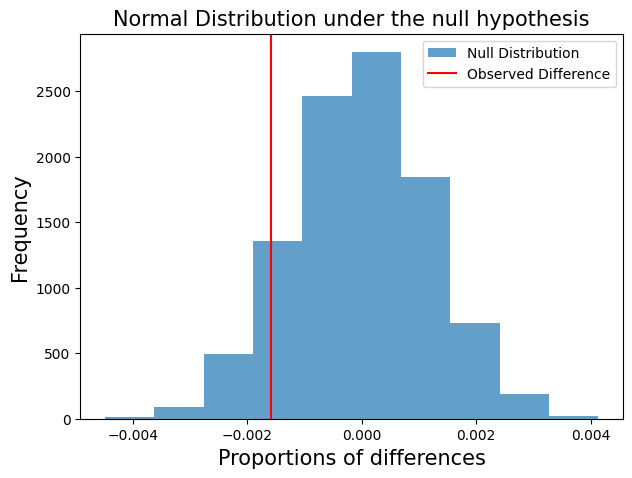

In [44]:
null_vals= np.random.normal(0, p_diffs.std(), p_diffs.size)

plt.figure(figsize=(7, 5))
plt.hist(null_vals, alpha=0.7, label='Null Distribution')
plt.axvline(observed_diff, c="red", label='Observed Difference')
plt.title('Normal Distribution under the null hypothesis', fontsize=15, fontweight="light")
plt.xlabel('Proportions of differences', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.legend()

plt.show()

**Observation:** The observed statistic is located close to the null value, suggesting no statistical difference in the observations of both pages

**Calculating p-value**

p-value can be calculated as the proportion of the p_diffs greater than the actual difference observed in the df2 data

In [37]:
p_val = (p_diffs > observed_diff).mean()
p_val

0.9061

The calculated p-value is significantly higher than the significance level α (0.05). We therefore fail to reject the null hypothesis (𝐻0)

---

## Results

#### Probability Analysis:

- The conversion rate of an individual regardless of the page they receive is 0.119
- The conversion rate of an individual to the new page is 0.118
- The conversion rate of an individual to the old page is 0.12
- The rate receiving of an individual to the new page is 0.5016
- The rate receiving of an individual to the old page is 0.498
- The difference observed in the conversion rate between the two pages is -0.001



#### A/B Hypothesis Testing:

The calculated p-value is significantly higher than the significance level α (0.05). We therefore fail to reject the null hypothesis$(H_0)$, which on the other hand means that there is no difference in the observations of both webpages, and that the conversion rate of the new webpage is not greater than the conversion rate of the old webpage.

---

## Conclusion

The results from A/B test shows that the new page has no statistically significant effect on the conversion rate.

---